In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [178]:
df = pd.read_csv('../csv/hourly_aqi_data.csv')

df.head(3)

,timestamp,city,dominentpol,temperature,humidity,pm1,pm10,pm25,aqi
0,2025-10-30 19:02:57,"NED University, Karachi",pm25,31.60,29.98,96,56,148,148
1,2025-10-30 19:07:07,"NED University, Karachi",pm25,31.58,29.85,96,56,150,150
2,2025-10-30 20:08:54,"NED University, Karachi",pm25,31.10,30.57,125,61,159,159


### Outliers detection and Removal

In [179]:
# Detect and Remove Outliers

def remove_outliers_iqr(df, columns):
    cleaned_df = df.copy()
    for col in columns:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower) & (cleaned_df[col] <= upper)]
    return cleaned_df.reset_index(drop=True)

In [180]:
# Columns to clean (adjust if needed)
cols_to_clean = ['aqi', 'temperature', 'humidity', 'pm1', 'pm10']

df = remove_outliers_iqr(df, cols_to_clean)

print(f"✅ Data after outlier removal: {df.shape[0]} rows")


✅ Data after outlier removal: 174 rows


## Feature Engineering

#### Plan of Attack, (Feature Engineering)
- Play with timestamp column, separate the hour, minutes, seconds etc etc
- Drop Extra features
- Apply OHE to the dominentpol as I don't know the exact order.
- Apply StandardScaler to all the numerical Columns ('temperature', 'humidity', 'pm1', 'pm10')
- Apply SimpleImputer with mean strategy to numerical columns
- Apply SimpleImputer with mode strategy to dominentpol (Categorical Variable)

### Handle TimeStamp

In [181]:
# Convert timestamp to datetime 

df['timestamp'] = pd.to_datetime(df['timestamp'])

In [182]:
# Sort data chronologically 

df = df.sort_values('timestamp')

In [183]:
# Extract time-based features 

df['hour'] = df['timestamp'].dt.hour 
df['day'] = df['timestamp'].dt.day 
df['month'] = df['timestamp'].dt.month 
df['day_of_week'] = df['timestamp'].dt.dayofweek 
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

In [184]:
# Lag features: previous AQI readings 

df['aqi_lag_1h'] = df['aqi'].shift(1)      # 1 hour ago 
df['aqi_lag_3h'] = df['aqi'].shift(3)      # 3 hours ago 
df['aqi_lag_6h'] = df['aqi'].shift(6)      # 6 hours ago
df['aqi_lag_12h'] = df['aqi'].shift(12)    # 12 hours ago
df['aqi_lag_24h'] = df['aqi'].shift(24)    # 24 hours ago
df['aqi_lag_48h'] = df['aqi'].shift(48)    # 48 hours ago
df['aqi_lag_72h'] = df['aqi'].shift(72)    # 72 hours ago


In [185]:
# Cyclical encoding for hour and day_of_week

df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
df['sin_dayofweek'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['cos_dayofweek'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

In [186]:
# Safe rolling means (no future leakage)

df['aqi_rolling_mean_3h'] = df['aqi'].shift(1).rolling(window=3, min_periods=1).mean()
df['aqi_rolling_mean_6h'] = df['aqi'].shift(1).rolling(window=6, min_periods=1).mean()
df['aqi_rolling_mean_12h'] = df['aqi'].shift(1).rolling(window=12, min_periods=1).mean()
df['aqi_rolling_mean_24h'] = df['aqi'].shift(1).rolling(window=24, min_periods=1).mean()
df['aqi_rolling_mean_48h'] = df['aqi'].shift(1).rolling(window=48, min_periods=1).mean()
df['aqi_rolling_mean_72h'] = df['aqi'].shift(1).rolling(window=72, min_periods=1).mean()

In [187]:
# Drop rows with NaN created by lag/rolling 

df = df.dropna()

### Dropping Extra Columns

In [188]:
df = df.drop(['city', 'pm25', 'dominentpol'], axis = 1)

In [189]:
df.columns

Index(['timestamp', 'temperature', 'humidity', 'pm1', 'pm10', 'aqi', 'hour',
       'day', 'month', 'day_of_week', 'is_weekend', 'aqi_lag_1h', 'aqi_lag_3h',
       'aqi_lag_6h', 'aqi_lag_12h', 'aqi_lag_24h', 'aqi_lag_48h',
       'aqi_lag_72h', 'sin_hour', 'cos_hour', 'sin_dayofweek', 'cos_dayofweek',
       'aqi_rolling_mean_3h', 'aqi_rolling_mean_6h', 'aqi_rolling_mean_12h',
       'aqi_rolling_mean_24h', 'aqi_rolling_mean_48h', 'aqi_rolling_mean_72h'],
      dtype='object')

### Creating the Pipeline 

In [190]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle

In [193]:
numeric_features = [
    'temperature', 'humidity', 'pm1', 'pm10', 'hour', 'day', 'month', 'day_of_week', 'is_weekend',
    'aqi_lag_1h', 'aqi_lag_3h', 'aqi_lag_6h', 'aqi_lag_12h', 'aqi_lag_24h', 'aqi_lag_48h', 'aqi_lag_72h', 'sin_hour', 'cos_hour', 
    'sin_dayofweek', 'cos_dayofweek', 'aqi_rolling_mean_3h', 'aqi_rolling_mean_6h', 'aqi_rolling_mean_12h', 
    'aqi_rolling_mean_24h', 'aqi_rolling_mean_48h', 'aqi_rolling_mean_72h'
]

In [194]:
# Numeric transformation: impute + scale

numeric_transformer = Pipeline([
    ('simple_imputer_numerical', SimpleImputer(strategy='mean')),
    ('scaling_numeric', StandardScaler())
])

In [195]:

feature_engineering = ColumnTransformer([
    ('numeric', numeric_transformer, numeric_features)
])

In [196]:
pipe = Pipeline([
    ('feature_engineering_Pipeline', feature_engineering)
])

### For Visualize the Pipeline

In [197]:
from sklearn import set_config
set_config(display = 'diagram')

In [198]:
pipe.fit(df)

,steps,"[('feature_engineering_Pipeline', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Understanding the Pipe and finding the names of OHE features

In [199]:
pipe.named_steps

{'feature_engineering_Pipeline': ColumnTransformer(transformers=[('numeric',
                                  Pipeline(steps=[('simple_imputer_numerical',
                                                   SimpleImputer()),
                                                  ('scaling_numeric',
                                                   StandardScaler())]),
                                  ['temperature', 'humidity', 'pm1', 'pm10',
                                   'hour', 'day', 'month', 'day_of_week',
                                   'is_weekend', 'aqi_lag_1h', 'aqi_lag_3h',
                                   'aqi_lag_6h', 'aqi_lag_12h', 'aqi_lag_24h',
                                   'aqi_lag_48h', 'aqi_lag_72h', 'sin_hour',
                                   'cos_hour', 'sin_dayofweek', 'cos_dayofweek',
                                   'aqi_rolling_mean_3h', 'aqi_rolling_mean_6h',
                                   'aqi_rolling_mean_12h',
                            

In [200]:
# ✅ Get all the column names

features_scaled = pipe.fit_transform(df)

all_cols = numeric_features

all_cols

['temperature',
 'humidity',
 'pm1',
 'pm10',
 'hour',
 'day',
 'month',
 'day_of_week',
 'is_weekend',
 'aqi_lag_1h',
 'aqi_lag_3h',
 'aqi_lag_6h',
 'aqi_lag_12h',
 'aqi_lag_24h',
 'aqi_lag_48h',
 'aqi_lag_72h',
 'sin_hour',
 'cos_hour',
 'sin_dayofweek',
 'cos_dayofweek',
 'aqi_rolling_mean_3h',
 'aqi_rolling_mean_6h',
 'aqi_rolling_mean_12h',
 'aqi_rolling_mean_24h',
 'aqi_rolling_mean_48h',
 'aqi_rolling_mean_72h']

In [201]:
# Convert to DataFrame

import pandas as pd
features_scaled_df = pd.DataFrame(features_scaled, columns=all_cols)

# Add target (aqi) and timestamp for reference
features_scaled_df['aqi'] = df['aqi'].values
features_scaled_df['timestamp'] = df['timestamp'].values

In [202]:
features_scaled_df.head()

,temperature,humidity,pm1,pm10,hour,day,month,day_of_week,is_weekend,aqi_lag_1h,...,sin_dayofweek,cos_dayofweek,aqi_rolling_mean_3h,aqi_rolling_mean_6h,aqi_rolling_mean_12h,aqi_rolling_mean_24h,aqi_rolling_mean_48h,aqi_rolling_mean_72h,aqi,timestamp
0,0.048627,1.340682,-0.278585,-0.075766,-0.333443,-1.591508,0.0,-1.591508,0.0,0.503729,...,-0.779076,1.543191,0.341525,0.451485,1.026050,1.608483,2.534735,1.936505,120,2025-11-03 10:08:10
1,0.563577,1.026750,-0.251130,-0.075766,-0.188715,-1.591508,0.0,-1.591508,0.0,-0.195324,...,-0.779076,1.543191,0.330956,0.451485,0.808942,1.343455,2.405405,1.913415,123,2025-11-03 11:12:14
2,0.884905,0.875170,0.188146,0.346867,-0.043986,-1.591508,0.0,-1.591508,0.0,-0.107942,...,-0.779076,1.543191,0.077299,0.410130,0.568982,1.140181,2.292722,1.891150,147,2025-11-03 12:09:37
3,1.099124,1.125239,-0.278585,-0.075766,0.100742,-1.591508,0.0,-1.591508,0.0,0.591111,...,-0.779076,1.543191,0.109006,0.238803,0.515657,1.099011,2.192843,1.881255,122,2025-11-03 13:12:05
4,1.160918,1.035983,-0.498223,-0.498399,0.245471,-1.591508,0.0,-1.591508,0.0,-0.137069,...,-0.779076,1.543191,0.130144,0.244711,0.359493,1.019246,2.076319,1.851568,107,2025-11-03 14:10:30


## Storing the Features to Hopswork

In [203]:
import hopsworks

In [204]:
project = hopsworks.login()
fs = project.get_feature_store()

2025-11-08 00:49:36,929 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-08 00:49:37,115 INFO: Initializing external client
2025-11-08 00:49:37,119 INFO: Base URL: https://c.app.hopsworks.ai:443




To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'


2025-11-08 00:49:44,767 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271970


In [205]:
# create or get a feature group object

fg = fs.get_or_create_feature_group(
    name="aqi_scaled_features_10pearls",
    version=1,
    description="Scaled + engineered AQI features used by models",
    primary_key=["timestamp"],   
    event_time="timestamp"       
)

In [206]:
# insert the Features into the Feature Store

fg.insert(features_scaled_df, wait=True)

Uploading Dataframe: 100.00% |█████████████████████████████| Rows 102/102 | Elapsed Time: 00:05 | Remaining Time: 00:00


Launching job: aqi_scaled_features_10pearls_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1271970/jobs/named/aqi_scaled_features_10pearls_1_offline_fg_materialization/executions
2025-11-08 00:50:39,720 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-08 00:50:52,263 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-08 00:55:21,638 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-08 00:55:22,466 INFO: Waiting for log aggregation to finish.
2025-11-08 00:55:57,725 INFO: Execution finished successfully.


(Job('aqi_scaled_features_10pearls_1_offline_fg_materialization', 'SPARK'),
 None)

## Fetch the Scaled Features from Hopswork to Train Models

In [207]:
project = hopsworks.login()

fs = project.get_feature_store()

2025-11-08 00:56:00,236 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-08 00:56:00,258 INFO: Initializing external client
2025-11-08 00:56:00,258 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-08 00:56:03,151 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271970


In [208]:
fg = fs.get_feature_group(
    name="aqi_scaled_features_10pearls",
    version=1
)

In [209]:
df_scaled = fg.read()

df_scaled.head()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (8.29s) 


,temperature,humidity,pm1,pm10,hour,day,month,day_of_week,is_weekend,aqi_lag_1h,...,sin_dayofweek,cos_dayofweek,aqi_rolling_mean_3h,aqi_rolling_mean_6h,aqi_rolling_mean_12h,aqi_rolling_mean_24h,aqi_rolling_mean_48h,aqi_rolling_mean_72h,aqi,timestamp
0,-2.732099,-0.206663,-0.113857,0.286491,-1.057086,0.663129,0.0,0.663129,0.0,1.115400,...,0.067402,-1.007797,1.039082,1.219502,1.288863,-0.403672,-0.715155,-1.010721,142,2025-11-06 05:41:12+00:00
1,-0.260342,-0.594461,-0.306040,-0.196519,0.969114,1.414674,0.0,1.414674,0.0,-0.952631,...,-1.625554,-1.007797,-1.095865,-0.972300,0.058590,1.181350,0.651130,-0.445850,115,2025-11-07 19:07:19+00:00
2,-1.504460,0.455825,1.670704,1.554390,-0.622901,1.414674,0.0,1.414674,0.0,0.940637,...,-1.625554,-1.007797,1.239894,1.432184,1.810682,1.410355,0.295154,-0.393898,174,2025-11-07 08:34:53+00:00
3,0.040388,-0.855301,0.050872,0.527996,-1.780730,-0.088417,0.0,-0.088417,0.0,0.212457,...,1.122943,-0.097360,0.394370,-0.021141,-1.240244,-0.936301,-0.680582,0.087686,151,2025-11-05 00:05:06+00:00
4,-1.413829,-0.489047,-0.004037,0.286491,-1.346544,0.663129,0.0,0.663129,0.0,1.319291,...,0.067402,-1.007797,1.261032,1.556248,0.595644,-0.442268,-0.847046,-0.995878,141,2025-11-06 03:07:21+00:00


## Train and compare the ML Models 

### Train Test Split

In [210]:
df_scaled.columns

Index(['temperature', 'humidity', 'pm1', 'pm10', 'hour', 'day', 'month',
       'day_of_week', 'is_weekend', 'aqi_lag_1h', 'aqi_lag_3h', 'aqi_lag_6h',
       'aqi_lag_12h', 'aqi_lag_24h', 'aqi_lag_48h', 'aqi_lag_72h', 'sin_hour',
       'cos_hour', 'sin_dayofweek', 'cos_dayofweek', 'aqi_rolling_mean_3h',
       'aqi_rolling_mean_6h', 'aqi_rolling_mean_12h', 'aqi_rolling_mean_24h',
       'aqi_rolling_mean_48h', 'aqi_rolling_mean_72h', 'aqi', 'timestamp'],
      dtype='object')

In [211]:
X = df_scaled.drop(['aqi', 'timestamp'], axis = 1)
y = df_scaled['aqi']

In [212]:
from sklearn.model_selection import train_test_split

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.shape

(92, 26)

### Train and Fine Tune the Models

In [214]:
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [215]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, use_label_encoder=False, verbosity=0)
svr = SVR()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()


In [216]:
# Grid Search CV on XGBoost

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [0.1, 1.0, 10.0]
}

search_cv_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

search_cv_xgb.fit(X_train, y_train)

# Get the best parameters of XGBoostRegressor
best_params_xgb = search_cv_xgb.best_params_
print("The Best Parameters of XGBoostRegressor are:", best_params_xgb)

best_xgb_model = XGBRegressor(**best_params_xgb)

The Best Parameters of XGBoostRegressor are: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_lambda': 0.1, 'subsample': 0.6}


In [217]:
# Grid Search CV on Support Vector Regressor

param_grid_svr = {
    'kernel': ['rbf', 'poly'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2],
    'gamma': ['scale', 'auto']
}

search_cv_svr = GridSearchCV(
    estimator=svr,
    param_grid=param_grid_svr,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

search_cv_svr.fit(X_train, y_train)

# Get the best parameters of SVR
best_params_svr = search_cv_svr.best_params_
print("The Best Parameters of SVR are:", best_params_svr)

best_svr_model = SVR(**best_params_svr)

The Best Parameters of SVR are: {'C': 10, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}


In [218]:
# Grid Search CV on RandomForest

param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse'],
    'max_samples': [0.25, 0.50, 0.75, None],
    'max_depth': [2, 5, 7]
}

search_cv_rf = GridSearchCV(estimator = rf, 
                            param_grid = param_grid_rf, 
                            scoring = 'r2', 
                            cv = 5, 
                            n_jobs = -1)

search_cv_rf.fit(X_train, y_train)

# Get the best parameters of RandomForestRegressor
best_params_rf = search_cv_rf.best_params_

print("The Best Parameters of RandomForestRegressor are: ", best_params_rf)

best_rf_model = RandomForestRegressor(**best_params_rf)

The Best Parameters of RandomForestRegressor are:  {'criterion': 'squared_error', 'max_depth': 5, 'max_samples': None, 'n_estimators': 100}


In [219]:
# Grid Search CV on GradientBoosting

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 4, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0]
}

search_cv_gb = GridSearchCV(estimator = gb, 
                            param_grid = param_grid_gb, 
                            scoring = 'r2', 
                            cv = 5, 
                            n_jobs = -1)

search_cv_gb.fit(X_train, y_train)

# Get the best parameters of GradientBoostingRegressor
best_params_gb = search_cv_gb.best_params_

print("The Best Parameters of GradientBoostingRegressor are: ", best_params_gb)

best_gb_model = GradientBoostingRegressor(**best_params_gb)

The Best Parameters of GradientBoostingRegressor are:  {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}


In [220]:
# Now Try multiple models with the best parameters

results = []

models = {
    "XG Boost": best_xgb_model,
    "SVM": best_svr_model,
    "Random Forest": best_rf_model,
    "Gradient Boosting": best_gb_model
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    
    print(f"{name}: R2 Score = {r2:.4f}")
    print(f"{name}: Mean Square Error = {mse:.4f}")
    print(f"{name}: Mean Absolute Error = {mae:.4f}")
    print("")


    results.append({
        "Name": name,
        "R2_Score": r2  
    })

XG Boost: R2 Score = 0.9850
XG Boost: Mean Square Error = 12.8233
XG Boost: Mean Absolute Error = 2.7467

SVM: R2 Score = 0.6384
SVM: Mean Square Error = 308.6703
SVM: Mean Absolute Error = 14.6994

Random Forest: R2 Score = 0.9767
Random Forest: Mean Square Error = 19.8984
Random Forest: Mean Absolute Error = 3.7422

Gradient Boosting: R2 Score = 0.9830
Gradient Boosting: Mean Square Error = 14.4848
Gradient Boosting: Mean Absolute Error = 2.9939



## Find the Best Model

In [221]:
# Find best model based on R2 score

best_model_info = max(results, key=lambda x: x["R2_Score"])
best_model_name = best_model_info["Name"]

In [222]:
best_model_to_save = models[best_model_name]
best_model_to_save

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Save the best model

In [223]:
import pickle 

In [226]:
pickle.dump(best_model_to_save, open("../models/best_model.pkl", 'wb')) 

## Apply MultiOutputRegressor for Multi-step Forecasting

In [227]:
# Load the best saved model

base_model = pickle.load(open("../models/best_model.pkl", "rb"))

# Hours of prediction
HORIZON = 72

### Prepare the Data

In [228]:
# Sort the records in chronological order
df = df_scaled.sort_values("timestamp").reset_index(drop=True)        

# get the scaled features fetched from Hopswork
FEATURES = X.columns.tolist()

# Add 24 features (colunms) in the dataset as | current_hour | AQI | y+1 | y+2 | y+3 | ... | y+24 |
Y = pd.DataFrame({
    f"y_plus_{h}": df['aqi'].shift(-h) for h in range(1, HORIZON + 1)
})

# Drop last 24 rows of the dataset as they contains NAN (in lastly created columns)
valid_idx = Y.dropna().index
X_feat = df.loc[valid_idx, FEATURES].reset_index(drop=True)
Y = Y.loc[valid_idx].reset_index(drop=True)

### Train Model

In [229]:
from sklearn.multioutput import MultiOutputRegressor

mor = MultiOutputRegressor(base_model)
mor.fit(X_feat, Y)

,estimator,"XGBRegressor(...ate=None, ...)"
,n_jobs,None
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None


In [230]:
mor.feature_names_in_ = X_feat.columns.tolist()

In [231]:
# Save the model (MultiOutputRegressor)

pickle.dump(mor, open("../models/best_forecast_model.pkl", "wb"))

### Make Predictions for Next 72 Hours

In [232]:
# Get the last row of your dataframe
last_row = df.iloc[-1]

# Select only the features you trained on
X_last = last_row[FEATURES]

# Convert that single row (Series) into a DataFrame and transpose it
X_last = X_last.to_frame().T

# Ensure all columns are numeric (convert if needed)
X_last = X_last.astype(float)

# Predict the next 24-hour AQI values
preds_72 = mor.predict(X_last).flatten()

print(preds_72)


[146.24019  140.9457   145.0949   130.5882   124.27786  129.43886
 136.45116  147.52866  135.08688  138.57617  116.95406  109.583115
 128.5566   143.11736  114.70239  104.88625  119.2198    91.512115
  89.4455   108.198006 112.32872  139.29358  147.37222  148.31241
 162.52977  127.09645  127.90469  135.65938  130.816    123.37121
 136.57413  149.22273  145.71881  108.64941   92.546425  81.512436
  93.37199   86.10973   78.0884    87.01138  115.39514  126.38868
 133.89456  134.78668  143.75285  149.51862  146.06406  144.34264
 136.16937  145.19412   97.12773  103.191734 118.97062  111.77366
 114.21038  112.178734  99.12289  100.61088  104.51994  143.52068
 116.03368  109.67198  121.29323  140.25381  146.00858  140.4684
 168.0717   171.0023   152.16362  171.93924  163.83559  161.16367 ]


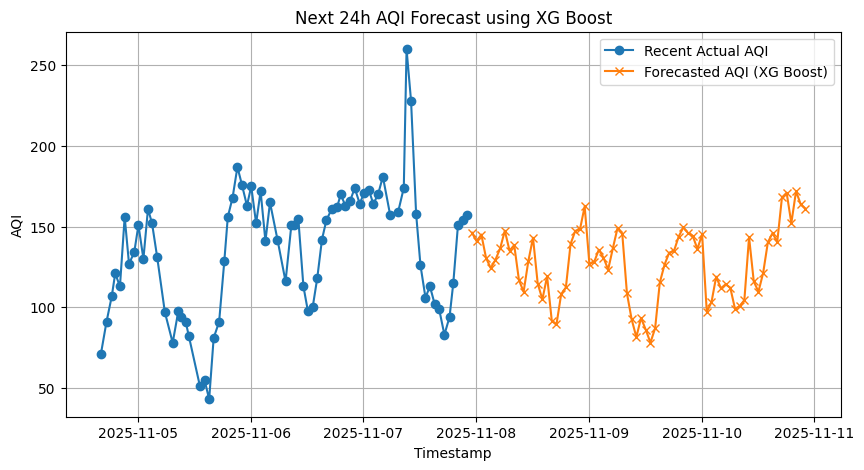

In [233]:
# Plotting

future_timestamps = [last_row['timestamp'] + pd.Timedelta(hours=i) for i in range(1, HORIZON+1)]
forecast_df = pd.DataFrame({'timestamp': future_timestamps, 'predicted_aqi': preds_72})

plt.figure(figsize=(10,5))
plt.plot(df.tail(75)['timestamp'], df.tail(75)['aqi'], label='Recent Actual AQI', marker='o')
plt.plot(forecast_df['timestamp'], forecast_df['predicted_aqi'], label=f'Forecasted AQI ({best_model_name})', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('AQI')
plt.title(f'Next 24h AQI Forecast using {best_model_name}')
plt.legend()
plt.grid(True)
plt.show()

## Save the Model to Hopswork 

In [239]:
import hopsworks
import pickle
import json

In [235]:
# Login to Hopsworks

project = hopsworks.login()
mr = project.get_model_registry()

2025-11-08 01:02:45,701 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-08 01:02:45,759 INFO: Initializing external client
2025-11-08 01:02:45,759 INFO: Base URL: https://c.app.hopsworks.ai:443




To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'


2025-11-08 01:02:59,412 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271970


In [236]:
# Register base model (single-step)

model_base = mr.python.create_model(
    name="aqi_base_model",
    description="Best single-step AQI prediction model (trained on scaled features)"
)
model_base.save("../models/best_model.pkl")

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading C:\Users\cw\Data Science\Projects\10Pearls\Scripts\src\../models/best_model.pkl: 0.000%|          | …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1271970/models/aqi_base_model/18


Model(name: 'aqi_base_model', version: 18)

In [238]:
# Register forecast model

model_forecast = mr.python.create_model(
    name="aqi_forecast_model",
    description="Multi-output 24-hour AQI forecasting model"
)
model_forecast.save("../models/best_forecast_model.pkl")

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading C:\Users\cw\Data Science\Projects\10Pearls\Scripts\src\../models/best_forecast_model.pkl: 0.000%|   …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1271970/models/aqi_forecast_model/14


Model(name: 'aqi_forecast_model', version: 14)